In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [3]:
# Configura la longitud de la secuencia y el horizonte de predicción
sequence_length = 24  #  24 pasos (2h 24min)
horizon = 1           # Predicción 1 paso adelante

# Función para crear ventanas de tiempo
def create_dataset(X, y, sequence_length=24, horizon=1):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length - horizon + 1):
        Xs.append(X[i:(i + sequence_length)])
        ys.append(y[i + sequence_length + horizon - 1])
    return np.array(Xs), np.array(ys)

In [4]:
current_dir = os.getcwd()

X_train_path = os.path.join('..', 'data', 'processed', 'X_train.csv')
X_test_path = os.path.join('..', 'data', 'processed', 'X_test.csv')
y_train_path = os.path.join('..', 'data', 'processed', 'y_train.csv')
y_test_path = os.path.join('..', 'data', 'processed', 'y_test.csv')



In [5]:
print(X_test_path)
print(os.path.exists(X_test_path))

../data/processed/X_test.csv
True


In [50]:
scaler = MinMaxScaler(feature_range=(-1, 1))

X_train = pd.read_csv(X_train_path, index_col= 9)
X_test = pd.read_csv(X_test_path, index_col= 9)
y_train = pd.read_csv(y_train_path, index_col= 0)
y_test = pd.read_csv(y_test_path, index_col= 0)

#Escalar los datos 
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), 
                              index=X_train.index, 
                              columns=X_train.columns)

X_test_scaled = pd.DataFrame(scaler.transform(X_test), 
                             index=X_test.index, 
                             columns=X_test.columns)


Despues de cargados los dataframes vamos a construir el modelo con Keras, trataremos de predecir en simultaneo la temperatura y precipitación usando una RNN

Primero nos aseguraremos que las dimensiones de los dataframes sean las adecuadas.

N_features hace referencia a la cantidad de variables categoricas que miden en cada paso con el paso del tiempo. que en nuestro caso será 9 pues son viene dado por las columnas : 
- dd

- ff

- hu

- td

- month

- quarter

- dd_rad

- wind_u

- wind_v


In [62]:
X_train_seq, y_train_seq = create_dataset(X_train_scaled.values, y_train.values, sequence_length, horizon)
X_test_seq, y_test_seq = create_dataset(X_test_scaled.values, y_test.values, sequence_length, horizon)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, shuffle=False
)

In [63]:
N_features = X_train_final.shape[1]  # 9 características (excluyendo 'date')
N_timesteps = X_train_final.shape[1]  # Usaremos la misma cantidad de pasos de tiempo que características 
N_output = 2  # Para predecir temperatura (t) y precipitación (precip)

Usando LSTM

In [74]:
model = models.Sequential([
    layers.Input(shape=(sequence_length, X_train_seq.shape[2])),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_train_seq.shape[1])
])


In [75]:
# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Ver resumen del modelo
model.summary()

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 24, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,770 (534.26 KB)

 Trainable params: 136,770 (534.26 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
# Entrenamiento del modelo
history = model.fit(
    X_train_final, y_train_final, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=[early_stopping]
)

Epoch 1/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 58s 13ms/step - loss: 2417.5852 - mae: 16.8037 - val_loss: 27.5508 - val_mae: 2.9442
Epoch 2/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 140.3529 - mae: 6.7836 - val_loss: 53.9385 - val_mae: 4.7985
Epoch 3/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 73.9100 - mae: 4.8204 - val_loss: 4.2459 - val_mae: 1.3414
Epoch 4/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - loss: 33.0412 - mae: 3.2779 - val_loss: 0.8923 - val_mae: 0.4386
Epoch 5/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 28.9959 - mae: 3.0610 - val_loss: 2.3717 - val_mae: 0.9677
Epoch 6/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 59s 13ms/step - loss: 24.2604 - mae: 2.7895 - val_loss: 0.6519 - val_mae: 0.5215
Epoch 7/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 60s 13ms/step - loss: 19.4082 - mae: 2.5067 - val_loss: 0.4335 - val_mae: 0.4300
Epoch 8/100
4577/4577 ━━━━━━━━━━━━━━━━━━━━ 61s 13ms/step - loss: 14.1894 - mae: 2.1371 - val_loss: 0.7163 - val_mae: 0.5880
Ep

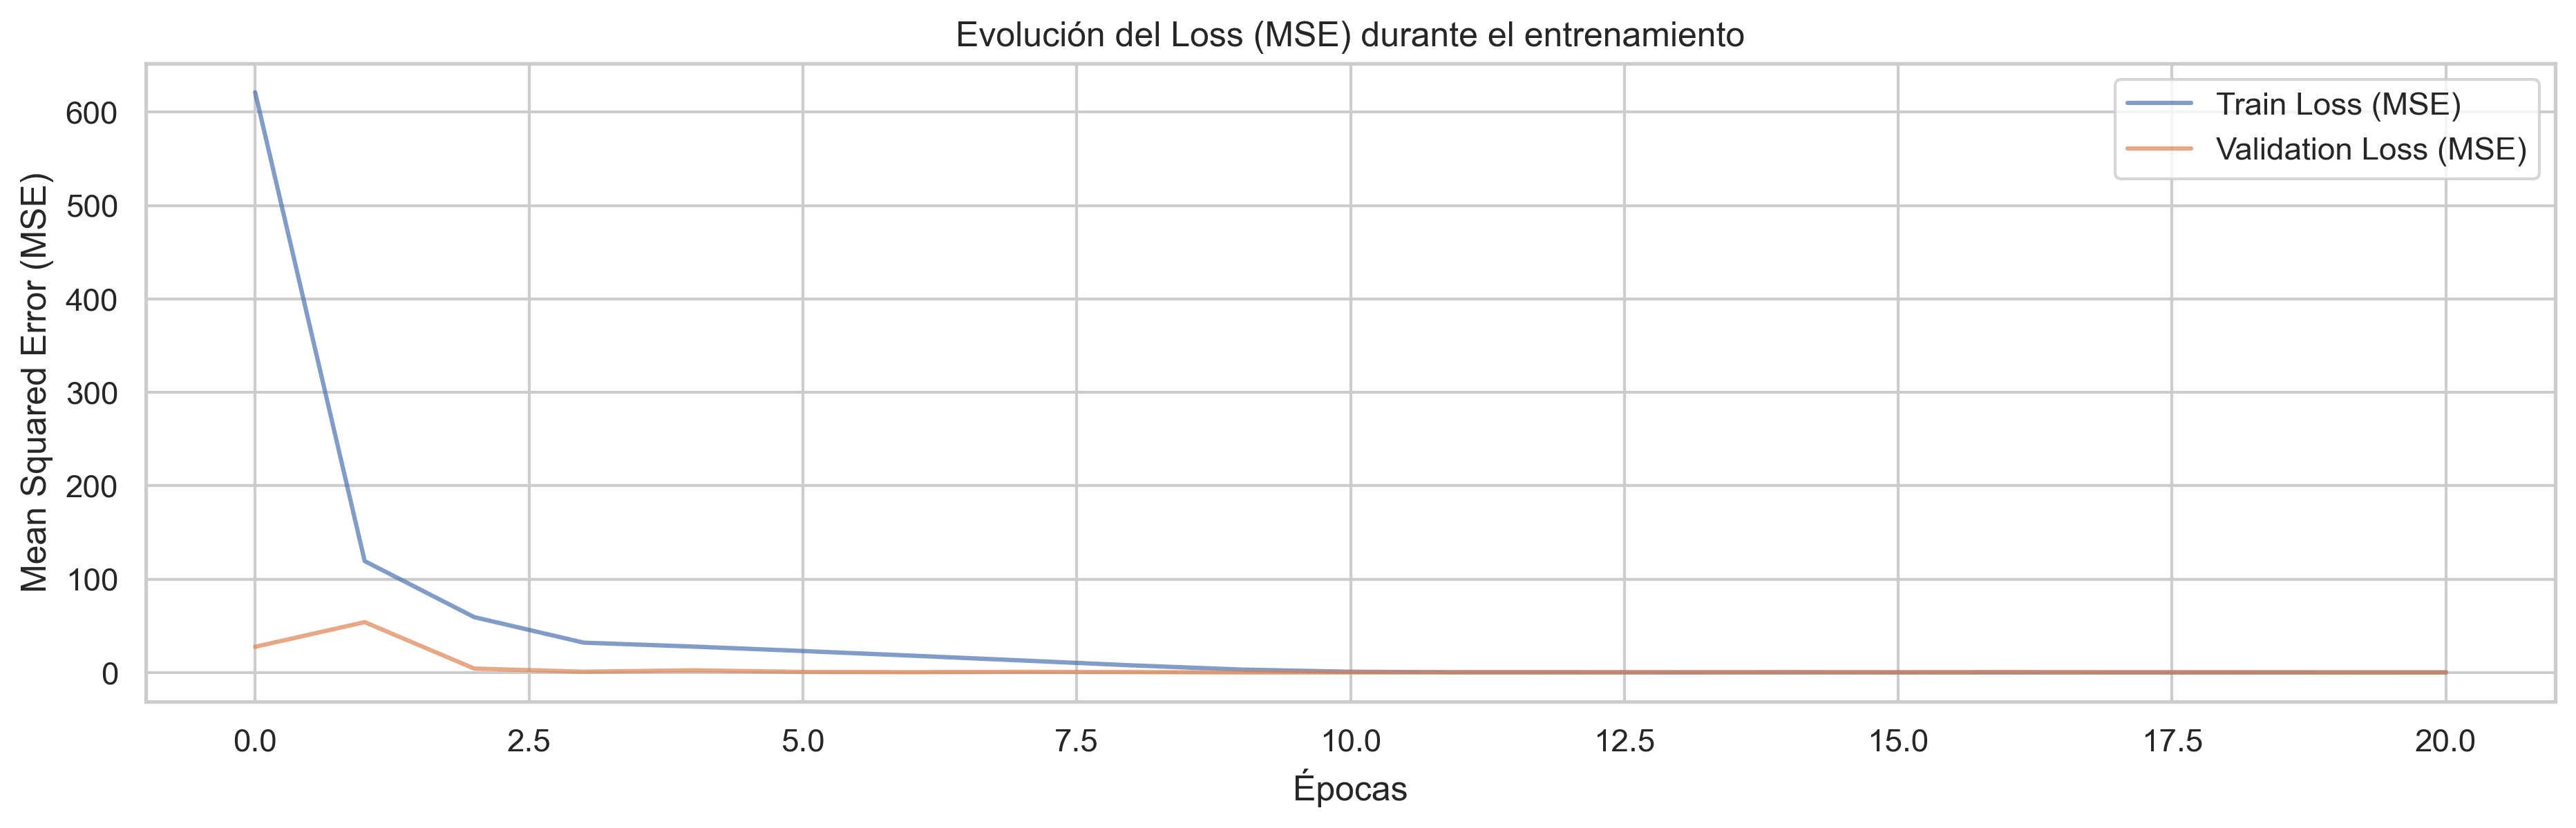

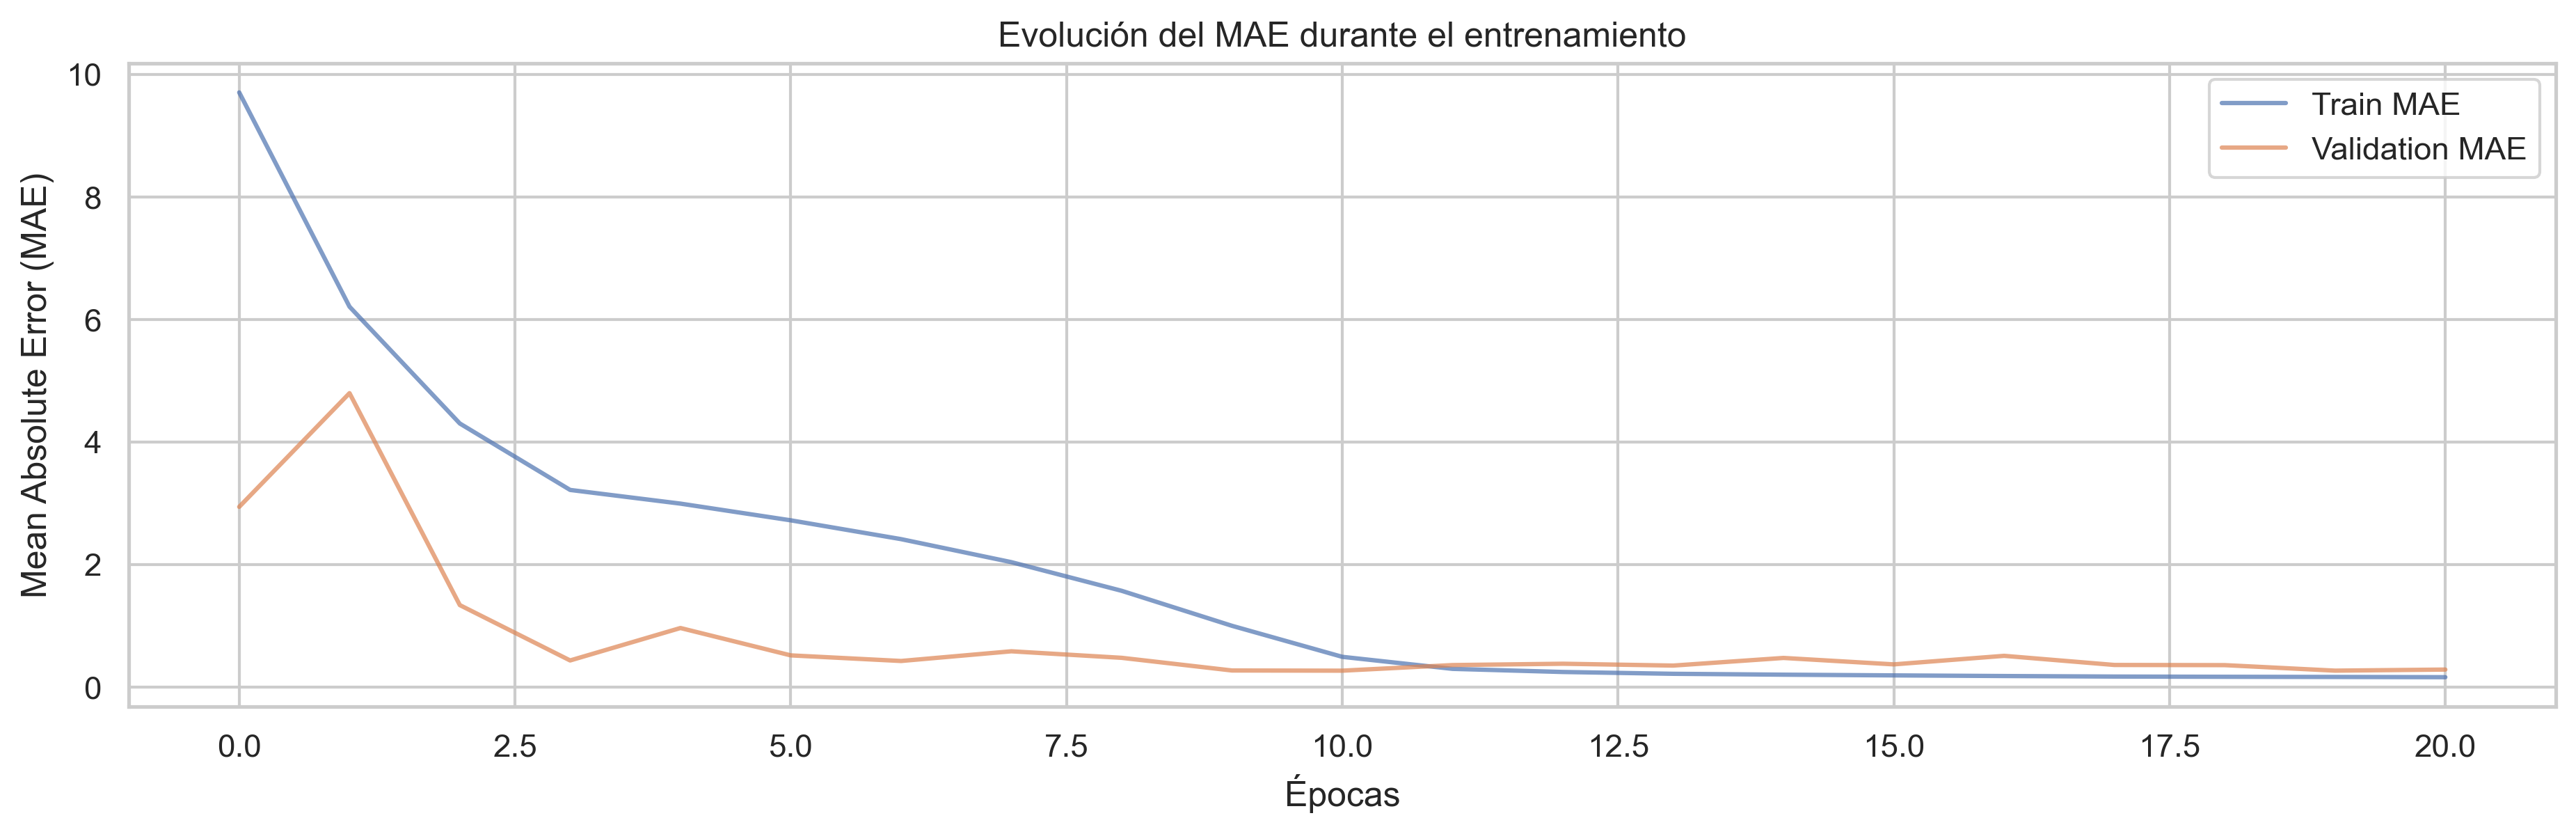

In [79]:
# Gráfica de la función de pérdida (MSE)
plt.figure(figsize=(15,4), dpi=300)
plt.plot(history.history['loss'], label='Train Loss (MSE)', alpha=0.7)
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)', alpha=0.7)
plt.title('Evolución del Loss (MSE) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)
plt.legend()
plt.show()

# Gráfica del MAE (Error absoluto medio)
plt.figure(figsize=(15,4), dpi=300)
plt.plot(history.history['mae'], label='Train MAE', alpha=0.7)
plt.plot(history.history['val_mae'], label='Validation MAE', alpha=0.7)
plt.title('Evolución del MAE durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss}")
print(f"Test MAE: {test_mae}")

Usando GRU

In [ ]:
model_gru = models.Sequential()

In [ ]:
# Capa GRU
model_gru.add(layers.GRU(units=64, return_sequences=False, input_shape=(N_timesteps, N_features)))

# Dropout para evitar sobreajuste
model_gru.add(layers.Dropout(0.2))

# Capa densa
model_gru.add(layers.Dense(64, activation='relu'))
model_gru.add(layers.Dropout(0.2))

# Capa de salida
model_gru.add(layers.Dense(N_output))


In [ ]:
model_gru.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [ ]:
model_gru.summary()

In [ ]:
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


In [ ]:
test_loss_gru, test_mae_gru = model_gru.evaluate(X_test, y_test)
print(f"GRU Test loss: {test_loss_gru}")
print(f"GRU Test MAE: {test_mae_gru}")

Haremos una comparación visual mediante graficos de entrenamiento y validacion para ver como se comporta la convergencia de los modelos y tambien su peridda

In [ ]:
# Graficar las pérdidas de entrenamiento y validación para LSTM y GRU
plt.plot(history.history['loss'], label='LSTM Train Loss')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Graficar los MAE de LSTM y GRU
plt.plot(history.history['mae'], label='LSTM Train MAE')
plt.plot(history.history['val_mae'], label='LSTM Validation MAE')
plt.plot(history_gru.history['mae'], label='GRU Train MAE')
plt.plot(history_gru.history['val_mae'], label='GRU Validation MAE')
plt.title('Train vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()